<a href="https://colab.research.google.com/github/ryanmansoor/CIPA-FYP/blob/master/Cost_of_Interconnection_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install overpass
!pip install mpu
!pip install geotiler

In [0]:
import overpass
import mpu
import sys
import math
import geotiler
from matplotlib import pyplot as plt
api = overpass.API()


This module applies to plant connections less than 25MW as per:
https://www.fingrid.fi/globalassets/dokumentit/en/customers/grid-connection/kantaverkkoon-liittyjan-opas_en.pdf

In [0]:
# OSM Map colors and Legend (Assosciated Costs Based on: https://www.wecc.org/Reliability/2014_TEPPC_Transmission_CapCost_Report_B+V.pdf)
osm_map_color_dict =	{
  "#e892a2": ("Motor Way", 1.70),
  "#dc2a67": ("Motor Way", 1.70),
  "#f9b29c": ("Main Road", 1.60),
  "#fcd6a4": ("Main Road", 1.60),
  "#f7fabf": ("Main Road", 1.60),
  "#c84e2f": ("Main Road", 1.60),
  "#a06b00": ("Main Road", 1.60),
  "#707d05": ("Main Road", 1.60),
  "#a97e27": ("Track", 1.2),
  "#57b257": ("Bridleway", 1.2),
  "#7a7cf6": ("Cycleway", 1.2),
  "#fa7671": ("Footway", 1.2),
  "#999999": ("Railway", 1.5),
  "#bcbcbc": ("Railway", 1.5),
  "#777777": ("Railway", 1.5),
  "#333333": ("Light Rail and Tram", 1.7),
  "#b7b7b7": ("Cable Car and Chairlift", 1.75),
  "#bdbdcd": ("Airport Runway and Taxiway", sys.maxsize),
  "#cc99ff": ("Airport Apron and Terminal", sys.maxsize),
  "#e3aeec": ("Administrative Boundary", 1.0),
  "#8dc56c": ("Forest", 2.25),
  "#aed1a0": ("Wood", 2.25),
  "#b5e3b5": ("Golf Course", sys.maxsize),
  "#b6fdb6": ("Park", sys.maxsize),
  "#aedfa3": ("Park", sys.maxsize),
  "#cccccc": ("Residential Area", 1.49),
  "#cfeca8": ("Common and Meadow", 1.0),
  "#f1dada": ("Retail Area", 1.69),
  "#ffaeb9": ("Industrial Area", 1.49),
  "#efc8c8": ("Commercial Area", 1.59),
  "#ffffc0": ("Heathland", 1),
  "#b5d0d0": ("Lake and Reservoir", sys.maxsize),
  "#ead8bd": ("Farm", 1),
  "#9d9d6c": ("Brownfield Site", 1.59),
  "#aacbaf": ("Cemetery", 1.8),
  "#c8b084": ("Allotments", 1),
  "#8ad3af": ("Sports Pitch", sys.maxsize),
  "#33cc99": ("Sports Centre", sys.maxsize),
  "#abdf96": ("Nature Reserve", sys.maxsize),
  "#cee3c5": ("Nature Reserve", sys.maxsize),
  "#e18f8f": ("Military Area", sys.maxsize),
  "#f0f0d8": ("School and University", sys.maxsize),
  "#eef0d5": ("Wetland", 1.2),
  "#cc9999": ("Significant Building", sys.maxsize),
  "#d08f55": ("Summit and Peak", 2.25),
  "#bdbece": ("Motorway", 1.70),
  "#9a9ab1": ("Motorway", 1.70),
  "#c8d8c8": ("Trunk Road", 1.5),
  "#abb5a4": ("Trunk Road", 1.5),
  "#d8c8c8": ("Primary Road", 1.5),
  "#f0e3e3": ("Primary Road", 1.5),
  "#d4b6b7": ("Primary Road", 1.5),
  "#dadacc": ("Secondary Road", 1.5),
  "#ededc8": ("Secondary Road", 1.5),
  "#c8b48a": ("Secondary Road", 1.5),
  "#9f6f0f": ("Track", 1.2),
  "#0100fe": ("Cycleway", 1.2),
  "#fe0000": ("National Cycleway", 1.2),
  "#28c8fe": ("Regional Cycleway", 1.2),
  "#b2b2ff": ("Local Cycleway", 1.2),
  "#bd6d6e": ("Footway", 1.2),
  "#cde1c4": ("Forest", 2.25),
  "#bcdd92": ("Common and Meadow", 1),
  "#f2efe8": ("Urban Area", 1.59),
  "#f4e1ec": ("Urban Area", 1.59),
  "#e0dfdf": ("Urban Area", 1.59),
  "#f2efe9": ("Urban Area", 1.59),
  "#f4f2ed": ("Urban Area", 1.59),
  "#f7f5f1": ("Urban Area", 1.59),
  "#add19e": ("Nature Reserve", sys.maxsize),
  "#aad3df": ("Water", sys.maxsize),
  "#d1d1d0": ("Common and Meadow", 1),
  "#ffffff": ("Road", 1.2),
  "#d9d0c9": ("Building", sys.maxsize),
  "#bfb0a4": ("Building", sys.maxsize),
}

In [0]:
# The Following Node Datatype is created to store each segment of the map, to perform graph search
class Node:

    def __init__(self, f=0, g=0, h=0, coordinates=[0, 0], cost=1.59):
        self.f = f
        self.g = g
        self.h = h
        self.coordinates = coordinates
        self.cost = cost


In [0]:
def get_closest_connection_point(start):
    """
    :param start: Lat Lng Coordinates of hypothetical plant
    :return: Coordinates and properties of closest substation or tower using the OverPass API
    """
    radius = 5000
    n_responses = 0
    while n_responses == 0:
        print('Searching for towers and substations at radius {}'.format(radius))
        response = api.get('node[power=tower](around:{2},{0},{1}); out; node[power=substation](around:{2},{0},{1})'
                        .format(start[0], start[1], radius))
        print('Found {} results')
        n_responses = len(response['features'])
        radius += 5000

        if radius == 50000:
            print('No results found within radius of 50000')
            n_responses = 1

    if len(response['features']) > 0:
        min_dist = 100000
        min = response['features'][0]

        for node in response['features']:
            coordinates = node['geometry']['coordinates']
            coordinates[0], coordinates[1] = coordinates[1], coordinates[0]
            dist = mpu.haversine_distance(start, coordinates)

            if dist < min_dist:
                min = node
                min_dist = dist
        print('coordinates:', coordinates, 'distance:', min_dist, min['properties'])
        return coordinates, min['properties']
    else:
        print("No results")


In [0]:
def gen_grid(start, end, zoom_level=16):

    """
    Generates a square grid containing coordinates encompassing start and end.
    :param start: Starting Coordinate (plant)
    :param end: Ending Coordinate (Tower or Substation)
    :return: 2D list containing coordinates
    """
    center = [(start[0]+end[0])/2, (start[1]+end[1])/2] # center coordinates

    dist_per_pix = 40075016.686 * math.cos(math.radians(center[0])) / (2**(zoom_level + 8)) # 40075016.686 is the circumference of the earth in meters
    grid_dist_pix = int(round(38/dist_per_pix))
    vertical_dist_lat = abs(start[0]-end[0])
    horizontal_dist_lon = abs(start[1]-end[1])
    # bounding area of image
    bot = center[0]-0.75*vertical_dist_lat
    L = center[1]-0.75*horizontal_dist_lon
    top = center[0]+0.75*vertical_dist_lat
    R = center[1]+0.75*horizontal_dist_lon

    bbox = L, bot, R, top # Bounding box corners of map image, in coordinates
    pix_vals, width, height = gen_map(bbox, _start, _end)
    n_grids_width = int(round(width/grid_dist_pix))
    n_grids_height = int(round(height/grid_dist_pix))
    lat_step_size = vertical_dist_lat / n_grids_height
    lon_step_size = horizontal_dist_lon / n_grids_width

    # Figuring out which index of the graph contains the start point and the end point
    if start[0] < end[0]:
        if start[1] < end[1]:
            start_idx = [int(round((1.25/1.5)*n_grids_height)) - 1, int(round((0.25/1.5)*n_grids_width)) - 1]
            end_idx = [int(round((0.25/1.5)*n_grids_height)) - 1, int(round((1.25/1.5)*n_grids_width)) - 1]
        else:
            start_idx = [int(round((1.25 / 1.5) * n_grids_height)) - 1, int(round((1.25 / 1.5) * n_grids_width)) - 1]
            end_idx = [int(round((0.25 / 1.5) * n_grids_height)) - 1, int(round((0.25 / 1.5) * n_grids_width)) - 1]
    else:
        if start[1] < end[1]:
            start_idx = [int(round((0.25/1.5)*n_grids_height)) - 1, int(round((0.25/1.5)*n_grids_width)) - 1]
            end_idx = [int(round((1.25/1.5)*n_grids_height)) - 1, int(round((1.25/1.5)*n_grids_width)) - 1]
        else:
            start_idx = [int(round((0.25 / 1.5) * n_grids_height)) - 1, int(round((1.25 / 1.5) * n_grids_height)) - 1]
            end_idx = [int(round((1.25 / 1.5) * n_grids_height)) - 1, int(round((0.25 / 1.5) * n_grids_height)) - 1]

    grid = [[0] * n_grids_width for i in range(n_grids_height)]
    lat = top
    # go through the grid
    for row in range(len(grid)):
        lon = L
        for column in range(len(grid[row])):
            cell_cost = []
            # Take the average cost of all pixels in each grid cell, ignoring unknown colors
            for row_pix in range(grid_dist_pix):
                for col_pix in range(grid_dist_pix):
                    pix_row_idx = row*grid_dist_pix + row_pix
                    pix_col_idx = column+grid_dist_pix + col_pix
                    color = pix_vals[pix_row_idx][pix_col_idx]
                    color = '#%02x%02x%02x' % color[:3]

                    try:
                        pix_cost = osm_map_color_dict[color][1]
                        cell_cost.append(pix_cost)
                    except KeyError:
                        # print("Pixel Colour", color, "Not found")
                        continue
            cost = sum(cell_cost)/len(cell_cost)

            new_node = Node(coordinates=[lat, lon], cost=cost)
            grid[row][column] = new_node

            lon += lon_step_size

        lat -= lat_step_size

    return grid, start_idx, end_idx, bbox



In [0]:
def gen_map(bbox, start, end, zoom_level=16):
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)

    #
    # download background map using OpenStreetMap
    #
    mm = geotiler.Map(extent=bbox, zoom=zoom_level)

    img = geotiler.render_map(mm)
    ax.imshow(img)
    width, height = img.size
    pixels = list(img.getdata())
    pixels = [pixels[i * width:(i + 1) * width] for i in range(height)]
    # plot custom points
    
    x0, y0 = start[1], start[0]
    x1, y1 = end[1], end[0]
    points = ((x0, y0), (x1, y1))
    x, y = zip(*(mm.rev_geocode(p) for p in points))
    ax.scatter(x, y, c='red', edgecolor='none', s=10, alpha=0.9)
    plt.text(x[0], y[0], 'start')
    plt.text(x[1], y[1], 'end')
    plt.savefig('ex-matplotlib.jpg', bbox_inches='tight')
    plt.show()
    plt.close()

    return pixels, width, height


In [0]:
# Function to be completed, for graph search on nodes with least cost path
def search(grid):
    open_set = []
    closed_set = []


configuration file /root/.config/geotiler/geotiler.ini does not exist


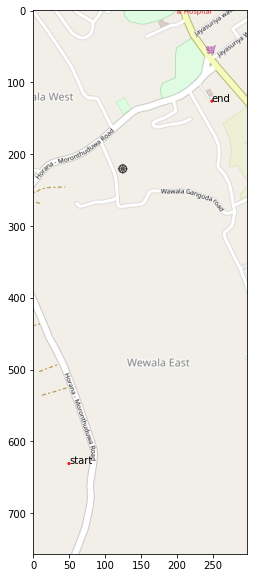

start idx [38, 2] end idx [7, 15]
start [6.7047482180850935, 80.05938168421055] (6.7, 80.06)
end [6.711841941489359, 80.06230463157904] [6.710755, 80.064272]


In [30]:
_start = (6.7, 80.06)
_end = [6.710755, 80.064272]
map_grid, start_idx, end_idx, _bbox = gen_grid(_start, _end)
print('start idx', start_idx, 'end idx', end_idx)
print('start', map_grid[start_idx[0]][start_idx[1]].coordinates, _start)
print('end', map_grid[end_idx[0]][end_idx[1]].coordinates, _end)

In [31]:
for row in range(len(map_grid)):
    for col in range(len(map_grid[row])):
        print("coordinates",map_grid[row][col].coordinates,"cost",map_grid[row][col].cost)

coordinates [6.71344375, 80.05893200000001] cost 1.5771604938271542
coordinates [6.71344375, 80.05915684210528] cost 1.5689626556016538
coordinates [6.71344375, 80.05938168421055] cost 1.558865546218482
coordinates [6.71344375, 80.05960652631582] cost 1.5483333333333282
coordinates [6.71344375, 80.05983136842109] cost 1.535502183406109
coordinates [6.71344375, 80.06005621052635] cost 1.523542600896857
coordinates [6.71344375, 80.06028105263162] cost 1.509495412844033
coordinates [6.71344375, 80.06050589473689] cost 1.4961792452830154
coordinates [6.71344375, 80.06073073684216] cost 1.4812499999999968
coordinates [6.71344375, 80.06095557894743] cost 1.4663414634146315
coordinates [6.71344375, 80.0611804210527] cost 1.4548514851485124
coordinates [6.71344375, 80.06140526315797] cost 1.445699999999998
coordinates [6.71344375, 80.06163010526323] cost 1.4410552763819078
coordinates [6.71344375, 80.0618549473685] cost 1.4390954773869327
coordinates [6.71344375, 80.06207978947377] cost 1.4417